# Deep Learning and Neural Networks
## Adding numbers using RNN

In [0]:
from __future__ import print_function
from keras.callbacks import EarlyStopping
import keras.backend as K 
from keras.models import Sequential
from keras import layers
import keras
import numpy as np
from six.moves import range
import itertools
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(12)

Using TensorFlow backend.


### Data Preparation

`CharacterTable` class help in encrypting and decrypting the input strings for the models. Returns a one hot encoded matrix after encrypting.

In [0]:
class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one-hot integer representation
    + Decode the one-hot or integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One-hot encode given string C.
        # Arguments
            C: string, to be encoded.
            num_rows: Number of rows in the returned one-hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        """Decode the given vector or 2D array to their character output.
        # Arguments
            x: A vector or a 2D array of probabilities or one-hot representations;
                or a vector of character indices (used with `calc_argmax=False`).
            calc_argmax: Whether to find the character index with maximum
                probability, defaults to `True`.
        """
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

In [0]:
chars = '0123456789+ '
ctable = CharacterTable(chars)    
REVERSE = False
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'
DIGITS = 3
MAXLEN = DIGITS + DIGITS + 1

#### Data Generation

`generateData` uses itertools to multiply two list of numbers from 0 to 999 to create the number pairs. These pairs are then converted into strings and paded if the lengths don't match and returns encoded string pairs for input and expected outputs.

In [0]:
def generateData(REVERSE, MAXLEN, DIGITS):
    data = np.arange(0,1000)
    data = np.asarray(list(itertools.product(data,data)))
    questions, expected = [], []
    for x in data:
        string = '{}+{}'.format(x[0], x[1])
        string = string + ' ' * (MAXLEN -len(string))
        answer = str(x[0]+x[1])
        answer += ' ' * (DIGITS + 1 - len(answer))
        if REVERSE:
            string = string[::-1]
        questions.append(string)
        expected.append(answer)
    questions = [ctable.encode(x, MAXLEN) for x in questions]
    expected = [ctable.encode(x, DIGITS+1) for x in expected]
    return np.array(questions, dtype=np.bool), np.array(expected, dtype=np.bool)

#### Vectorization

Shuffling the input and output values

In [0]:
%%time
questions, expected = generateData(REVERSE, MAXLEN, DIGITS)
indices = np.arange(len(expected))
np.random.shuffle(indices)
questions = questions[indices]
expected = np.array(expected)[indices]

CPU times: user 8.64 s, sys: 6.92 s, total: 15.6 s
Wall time: 15.6 s


### Model design and training
Spliting the data set into train and validation set with 90:10 ratio

In [0]:
split_at = len(expected) - len(expected) // 10
(x_train, x_val) = questions[:split_at], questions[split_at:]
(y_train, y_val) = expected[:split_at], expected[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

Training Data:
(900000, 7, 12)
(900000, 4, 12)
Validation Data:
(100000, 7, 12)
(100000, 4, 12)


In [0]:
Conf = {'Simple':layers.SimpleRNN, 'LSTM': layers.LSTM, 'GRU': layers.GRU}
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

#### Model

In [0]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''Calculates the mean aboslute percentage'''
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true),9,None))
    return 100. * K.mean(diff, axis=-1)  

In [0]:
def modelBuilder(HIDDEN_SIZE, in_dim, out_dim, DIGITS, LAYERS, RNN, rt_Seq, mets):
    '''Creates a RNN model with number of layers defined by LAYERS and input dimensions using in_dim and output dimensions using DIGITS and out_dim'''
    model = Sequential()
    model.add(RNN(HIDDEN_SIZE, input_shape=(in_dim[0], in_dim[1])))
    model.add(layers.RepeatVector(DIGITS + 1))
    for _ in range(LAYERS):
        model.add(RNN(HIDDEN_SIZE, return_sequences=rt_Seq))
    model.add(layers.TimeDistributed(layers.Dense(out_dim, activation='softmax')))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=mets)
    model.summary()
    return model

In [0]:
def evaluateModel(model, x_train, y_train, x_val, y_val, BATCH_SIZE, ctable, REVERSE, epochs=20):
    es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)
    # Train the model each generation and show predictions against the validation
    # dataset.
    loss, val_loss = [], []
    accuracy, val_accuracy = [], []
    for iteration in range(1, epochs+1):
        print('-' * 50)
        print('Iteration', iteration)
        history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs = 1, callbacks=[es], validation_data=(x_val, y_val)) 
        # Select 10 samples from the validation set at random so we can visualize
        # errors.
        if iteration ==1 or iteration%20 == 0:
          for i in range(10):
              ind = np.random.randint(0, len(x_val))
              rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
              preds = model.predict_classes(rowx, verbose=0)
              q = ctable.decode(rowx[0])
              correct = ctable.decode(rowy[0])
              guess = ctable.decode(preds[0], calc_argmax=False)
              print('Q', q[::-1] if REVERSE else q, end=' ')
              print('T', correct, end=' ')
              if correct == guess:
                  print(colors.ok + '☑' + colors.close, end=' ')
              else:
                  print(colors.fail + '☒' + colors.close, end=' ')
              print(guess)
        loss.append(history.history['loss'])
        val_loss.append(history.history['val_loss'])
        accuracy.append(history.history['accuracy'])
        val_accuracy.append(history.history['val_accuracy'])

    return model, loss, val_loss, accuracy, val_accuracy

In [0]:
def plotFigure(l1, l2, legend, label, title, fname):
    '''Names says it all plots figures'''
    fig = plt.figure(figsize=(12, 8))
    plt.plot(l1,'r', linewidth=3.0)
    plt.plot(l2,'b', linewidth=3.0)
    plt.legend(legend, fontsize=18)
    plt.xlabel(label[0], fontsize=18)
    plt.ylabel(label[1],fontsize=18)
    plt.title(title, fontsize=20)
    fig.savefig(fname)
    plt.show()

Simple RNN
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 128)               18048     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 4, 128)            32896     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 12)             1548      
Total params: 52,492
Trainable params: 52,492
Non-trainable params: 0
_________________________________________________________________
--------------------------------------------------
Iteration 1
Train on 900000 samples, validate on 100000 samples
Epoch 1/1
900000/900000 [==============================] - 22s 25us/step - loss: 1.1845 - mean_absolute_percentage_error: 

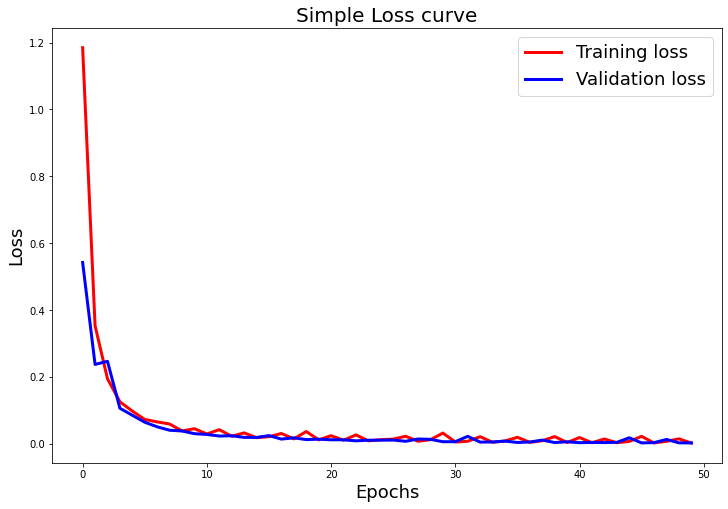

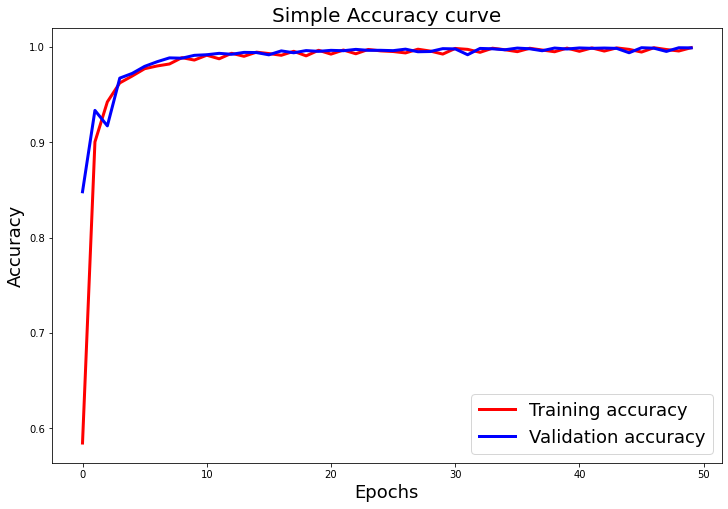

LSTM RNN
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________
--------------------------------------------------
Iteration 1
Train on 900000 samples, validate on 100000 samples
Epoch 1/1
900000/900000 [==============================] - 56s 63us/step - loss: 1.6599 - mean_absolute_percentage_error: 

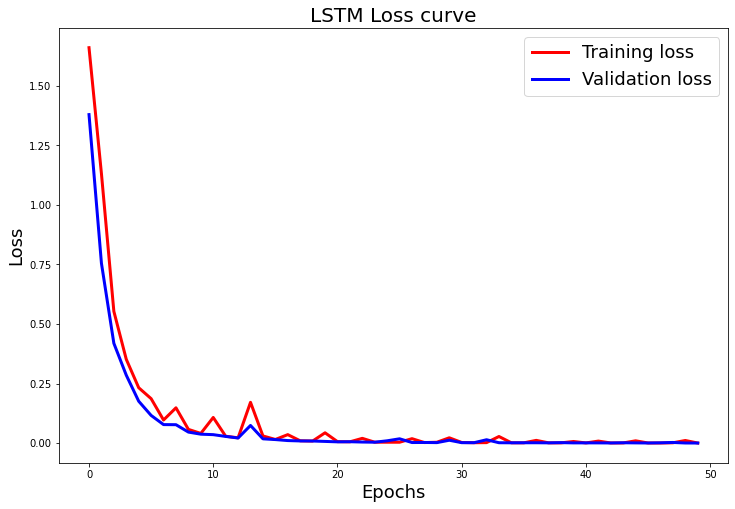

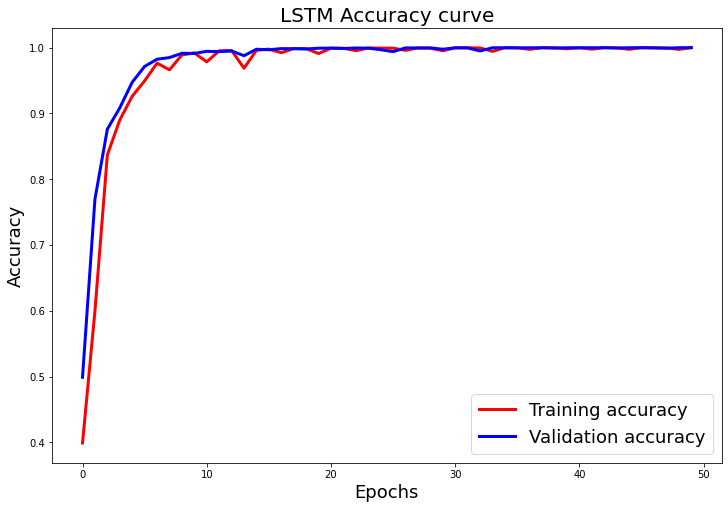

GRU RNN
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 128)               54144     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 4, 128)            98688     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 4, 12)             1548      
Total params: 154,380
Trainable params: 154,380
Non-trainable params: 0
_________________________________________________________________
--------------------------------------------------
Iteration 1
Train on 900000 samples, validate on 100000 samples
Epoch 1/1
900000/900000 [==============================] - 64s 71us/step - loss: 1.5721 - mean_absolute_percentage_error: 1

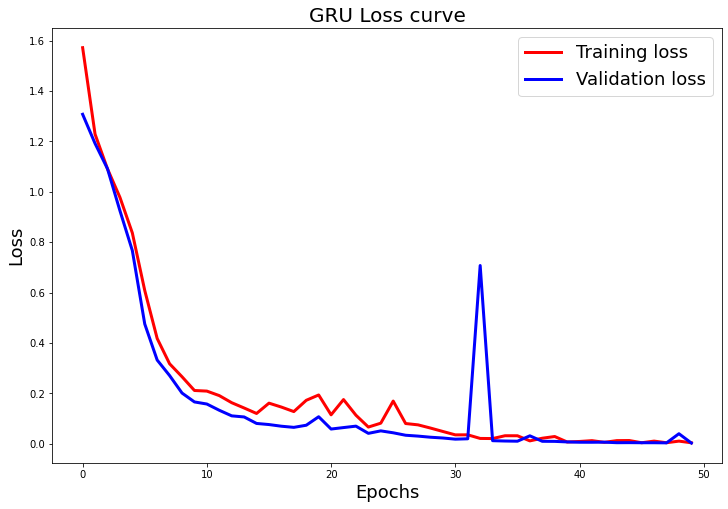

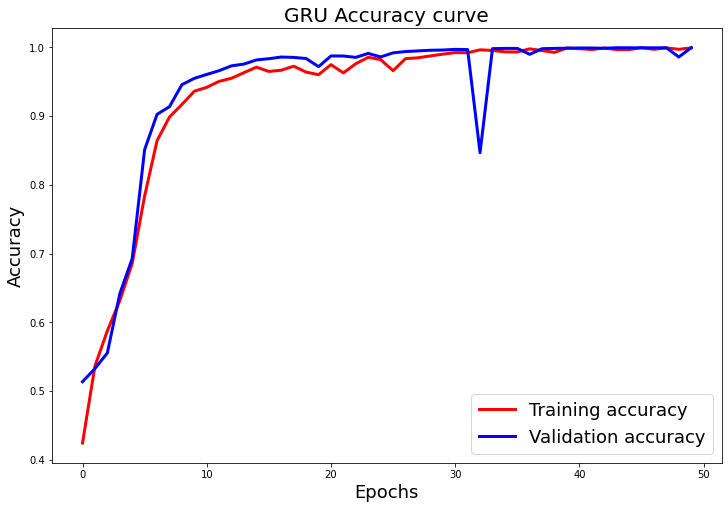

CPU times: user 2h 22min 1s, sys: 28min 15s, total: 2h 50min 17s
Wall time: 1h 56min 53s


In [0]:
%%time
## Runing 3 architectures for 50 epochs
for key, val in Conf.items():
    print(key+' RNN')
    model = modelBuilder(HIDDEN_SIZE, [MAXLEN, len(chars)], len(chars), DIGITS, LAYERS, val, True, [mean_absolute_percentage_error, 'accuracy', 'mse', 'mae'])
    model, l, vl, a, va = evaluateModel(model, x_train, y_train, x_val, y_val, BATCH_SIZE, ctable, REVERSE, 50)
    plotFigure(l, vl, ['Training loss', 'Validation loss'], ['Epochs', 'Loss'], str(key+ ' Loss curve'), str(key+'_Loss.png'))
    plotFigure(a, va, ['Training accuracy', 'Validation accuracy'], ['Epochs', 'Accuracy'], str(key+ ' Accuracy curve'), str(key+'_Acc.png'))

### String Reverse

Simple RNN
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 128)               18048     
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 4, 128)            32896     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 4, 12)             1548      
Total params: 52,492
Trainable params: 52,492
Non-trainable params: 0
_________________________________________________________________
--------------------------------------------------
Iteration 1
Train on 900000 samples, validate on 100000 samples
Epoch 1/1
900000/900000 [==============================] - 23s 25us/step - loss: 1.0576 - mean_absolute_percentage_error: 

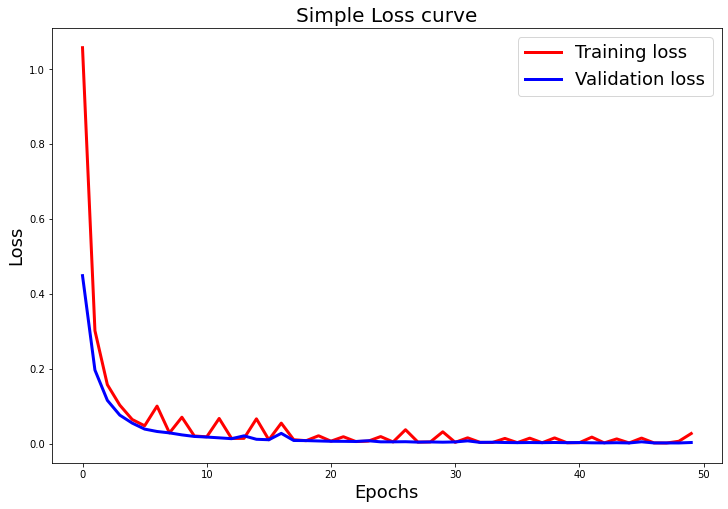

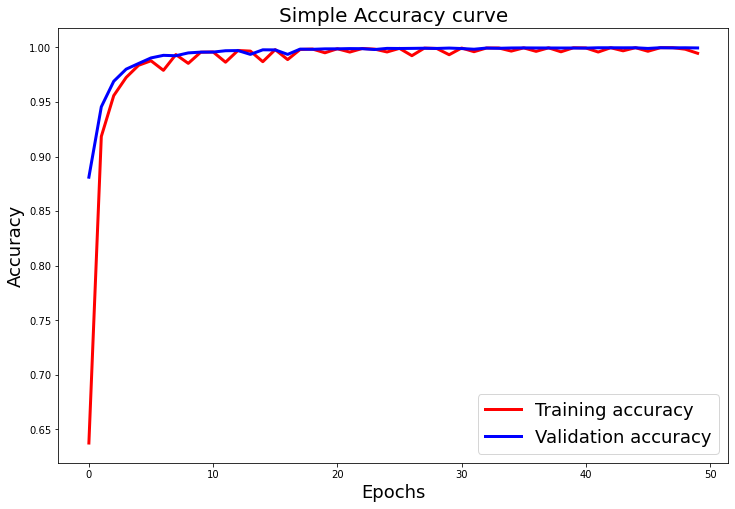

LSTM RNN
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________
--------------------------------------------------
Iteration 1
Train on 900000 samples, validate on 100000 samples
Epoch 1/1
900000/900000 [==============================] - 57s 63us/step - loss: 1.6615 - mean_absolute_percentage_error: 

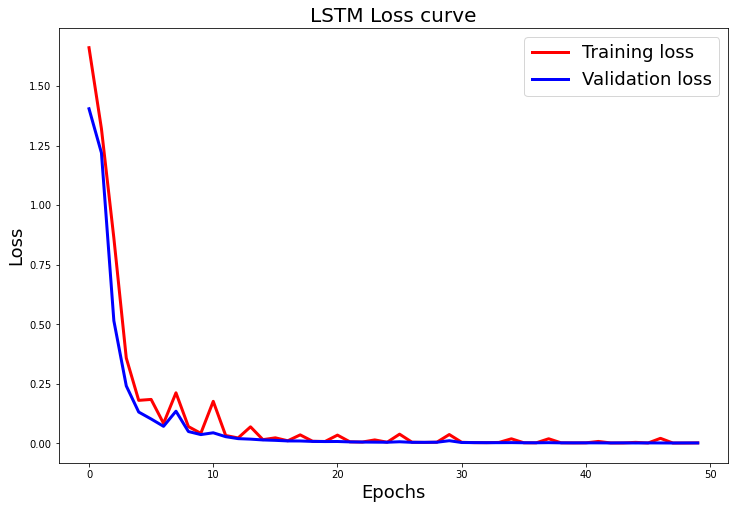

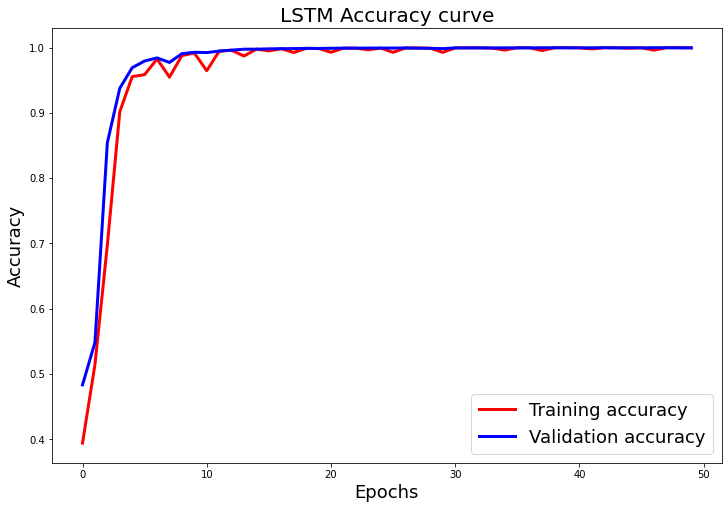

GRU RNN
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 128)               54144     
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
gru_4 (GRU)                  (None, 4, 128)            98688     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 4, 12)             1548      
Total params: 154,380
Trainable params: 154,380
Non-trainable params: 0
_________________________________________________________________
--------------------------------------------------
Iteration 1
Train on 900000 samples, validate on 100000 samples
Epoch 1/1
900000/900000 [==============================] - 68s 75us/step - loss: 1.5887 - mean_absolute_percentage_error: 1

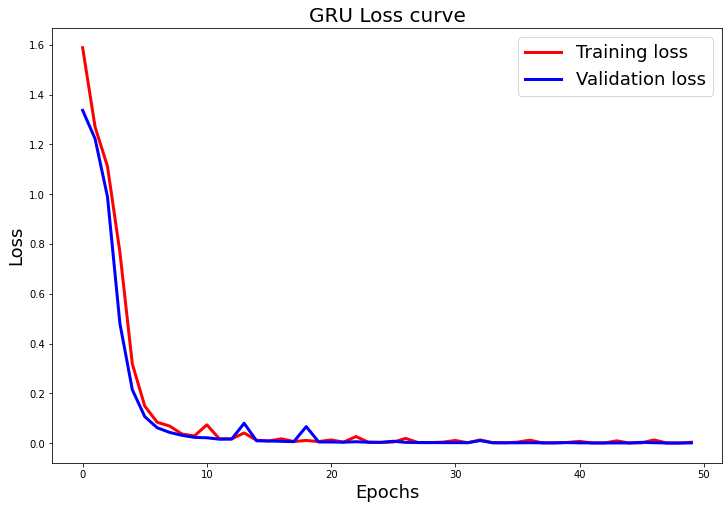

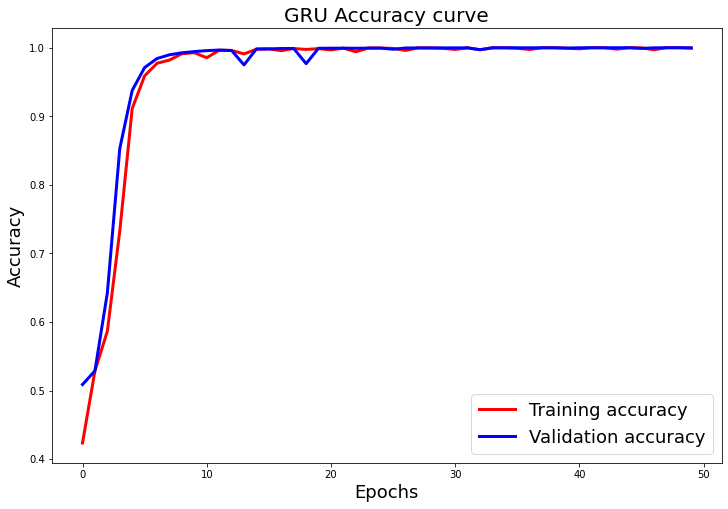

CPU times: user 2h 26min 42s, sys: 28min 58s, total: 2h 55min 40s
Wall time: 2h 37s


In [0]:
%%time
REVERSE = True
questions, expected = generateData(REVERSE, MAXLEN, DIGITS)
indices = np.arange(len(expected))
np.random.shuffle(indices)
questions = questions[indices]
expected = np.array(expected)[indices]

split_at = len(expected) - len(expected) // 10
(x_train, x_val) = questions[:split_at], questions[split_at:]
(y_train, y_val) = expected[:split_at], expected[split_at:]

for key, val in Conf.items():
    print(key+' RNN')
    model = modelBuilder(HIDDEN_SIZE, [MAXLEN, len(chars)], len(chars), DIGITS, LAYERS, val, True, [mean_absolute_percentage_error, 'accuracy', 'accuracy', 'mse', 'mae'])
    model, l, vl, a, va = evaluateModel(model, x_train, y_train, x_val, y_val, BATCH_SIZE, ctable, REVERSE, 50)
    plotFigure(l, vl, ['Training loss', 'Validation loss'], ['Epochs', 'Loss'], str(key+ ' Loss curve'), str(key+'_Loss_rev.png'))
    plotFigure(a, va, ['Training accuracy', 'Validation accuracy'], ['Epochs', 'Accuracy'], str(key+ ' Accuracy curve'), str(key+'_Acc_rev.png'))